# ORIE 4741 Project
### Netflix Success Predictor

In [486]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [487]:
netflix=pd.read_csv('datasets/netflix.csv')

In [488]:
netflix.head()

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6825000.0,NaN,2,NaN,NaN,Non-English,False,No,NaN,NaN,NaN,2022-04-03
1,10 Days of a Bad Man,Films,6900000.0,3300000.0,2,2.0667,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-08-27
2,10 Days of a Good Man,Films,7415000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-03-12
3,1000 Miles from Christmas,Films,6795000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2022-01-02
4,12 Strong,Films,8210000.0,NaN,2,NaN,NaN,English,False,No,NaN,NaN,NaN,2022-07-24


## Feature Engineering
Before we create a model in order to understand the features of importance for Netflix streaming content success and use it to predict how many views a show/film gets, we need to inspect the data and utilize feature engineering tools. 

#### Dealing with simple NaN values: 

In [489]:
def size_if_na_dropped(df):
  print(f"Out of {df.shape[0]} total points, if we drop all with missing data, \
we'll have {df.dropna().shape[0]} points (or {df.dropna().shape[0]/df.shape[0]} \
  of the original dataset)")

size_if_na_dropped(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


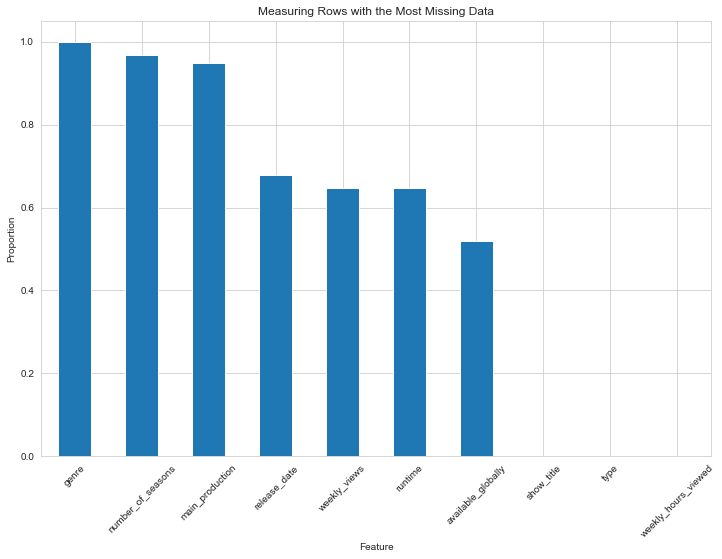

In [490]:
def plot_na(df):
  sns.set_style('whitegrid')
  plt.figure(figsize=(12,8))
  missing_vals = df.isna().sum()/df.shape[0]
  missing_vals = missing_vals.sort_values(ascending=False)[0:10]
  ax = missing_vals.plot(kind='bar')

  ax.set_title('Measuring Rows with the Most Missing Data')
  ax.set_ylabel('Proportion')
  ax.set_xlabel('Feature')
  ax.tick_params(axis='x', rotation=45)

plot_na(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


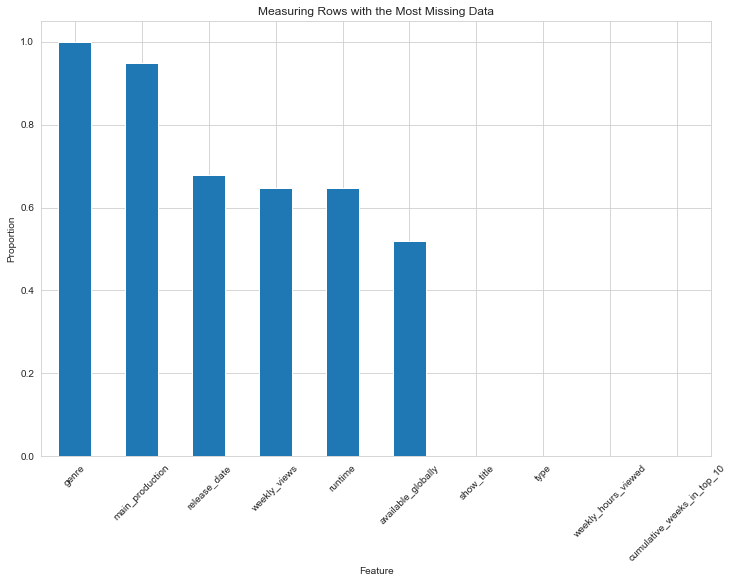

In [491]:
#The NaN values of number_of_seasons occur b/c they are films not shows, impute with 0
netflix['number_of_seasons'] = netflix['number_of_seasons'].fillna(0)
plot_na(netflix)
size_if_na_dropped(netflix)

#### Dealing with Categorical Values
There are a few categorical features in our data. To deal with them we will do the following
- One hot encoding the binary values: Language, Type, Available Globally
- Multi-hot encoding genre list

In [492]:
encoded_df= pd.get_dummies(netflix[['language','type','is_staggered_launch','available_globally' ]])
netflix = pd.concat([netflix.drop(columns=['language','type','is_staggered_launch','available_globally' ]), encoded_df], axis=1)
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-04-03,False,0,1,1,0,1,0
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,2.0667,0.0,NaN,NaN,NaN,2023-08-27,False,0,1,1,0,0,0
2,10 Days of a Good Man,7.415000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2023-03-12,False,0,1,1,0,0,0
3,1000 Miles from Christmas,6.795000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-01-02,False,0,1,1,0,0,0
4,12 Strong,8.210000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-07-24,False,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.8500,0.0,NaN,NaN,NaN,2024-01-21,False,0,1,1,0,0,0
1861,¡Que viva México!,1.249250e+07,NaN,4,NaN,0.0,2023-05-11,NaN,NaN,2023-06-04,False,0,1,1,0,0,1
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,1.9333,0.0,NaN,NaN,NaN,2023-10-22,False,0,1,1,0,0,0
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,NaN,0.0,2022-01-20,NaN,NaN,2022-02-06,False,0,1,1,0,1,0


#### Dealing with Missing Data


In [493]:
from numpy.linalg import svd

In [494]:
netflix_fill=netflix.copy()

In [495]:
#Imputing runtime values based on content type
meanfilm=netflix[netflix['type_Films']==1]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 1, 'runtime'] = netflix.loc[netflix['type_Films'] == 1, 'runtime'].fillna(meanfilm)
meantv=netflix[netflix['type_Films']==0]['runtime'].mean()
netflix_fill.loc[netflix_fill['type_Films'] == 0, 'runtime'] = netflix.loc[netflix['type_Films'] == 0, 'runtime'].fillna(meantv)

#Imputing availably globally
netflix_fill['available_globally_Yes'] = netflix_fill.apply(lambda row: True if row['language_Non-English'] == True else row['available_globally_Yes'], axis=1)

In [496]:
netflix_np=netflix_fill[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_np=netflix_np.astype(float)

In [497]:
column_means = np.nanmean(netflix_np, axis=0)
nan_indices = np.isnan(netflix_np)
netflix_np[nan_indices] = np.take(column_means, np.where(nan_indices)[1])

In [498]:
netflix_copy = netflix[['weekly_views',
       'cumulative_weeks_in_top_10', 'runtime', 'number_of_seasons',
       'is_staggered_launch', 'language_English', 'language_Non-English',
       'type_Films', 'type_TV', 'available_globally_No',
       'available_globally_Yes']].to_numpy()
netflix_copy=netflix_copy.astype(float)
netflix_copy2=netflix_copy.copy()

In [499]:
#Normalize ** DONT KNOW 
normalized_matrix = (netflix_np - np.mean(netflix_np, axis=0)) / np.std(netflix_np, axis=0)
U, S, VT = svd(normalized_matrix)

rank = 5
U_ranked = U[:, :rank]
S_ranked = np.diag(S[:rank])
VT_ranked = VT[:rank, :]
reconstructed_matrix = U_ranked.dot(S_ranked).dot(VT_ranked)

denormalized_matrix = (reconstructed_matrix * np.std(netflix_np, axis=0)) + np.mean(netflix_np, axis=0)

missing_indices = np.isnan(netflix_copy)
netflix_copy[missing_indices] = denormalized_matrix[missing_indices]



In [500]:
netflix_complete = pd.DataFrame(netflix_copy, columns=['weekly_views',
                                                  'cumulative_weeks_in_top_10', 'runtime', 
                                                  'number_of_seasons', 'is_staggered_launch', 
                                                  'language_English', 'language_Non-English', 
                                                  'type_Films', 'type_TV', 
                                                  'available_globally_No', 'available_globally_Yes'])
netflix_complete['weekly_hours_viewed']=netflix['weekly_hours_viewed']
netflix_complete.head()

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes,weekly_hours_viewed
0,2.530794e+06,2.0,1.465588,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,6825000.0
1,3.300000e+06,2.0,2.066700,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6900000.0
2,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7415000.0
3,3.670209e+06,2.0,1.835480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,6795000.0
4,3.629453e+06,2.0,1.428049,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,8210000.0


In [501]:
netflix=netflix_complete.copy()

## Modeling
Now that the feature engineering is completed. We will explore different models to find the best fit to predict our success variable
We will explore
- Linear Regression
- Polynomial Fits
- Regression Trees

In [502]:
#Linear Regression 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

y = netflix["weekly_hours_viewed"]
X = netflix.copy().drop(['weekly_hours_viewed'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("shape of X_train ", X_train.shape)
print("shape of y_train ", y_train.shape)
print("shape of X_test ", X_test.shape)
print("shape of y_test ", y_test.shape)



shape of X_train  (1492, 11)
shape of y_train  (1492,)
shape of X_test  (373, 11)
shape of y_test  (373,)


In [503]:
X_train

,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
898,3.500000e+06,1.0,1.650000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
244,4.516979e+06,1.0,1.782997,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
710,4.900000e+06,1.0,1.766700,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1190,3.124727e+06,3.0,5.227822,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
720,2.620949e+06,1.0,5.197934,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1130,4.876148e+06,6.0,5.375531,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1294,3.719608e+06,1.0,5.160395,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
860,4.190000e+06,7.0,8.400010,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1459,5.643615e+06,13.0,5.377257,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [504]:
linear_model = LinearRegression(fit_intercept=True).fit(X_train,y_train)
linear_pred = linear_model.predict(X_train)

In [505]:
#Vizualizations for the linear model made 

def plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()
  

def plot_residuals (y, y_pred):
  residuals = y - y_pred
  plt.scatter(y_pred, residuals)
  plt.xlabel("Predicted Values")
  plt.ylabel("Residuals")
  plt.title("Residual Plot")
  plt.axhline(y=0, color='r', linestyle='-')
  plt.show()


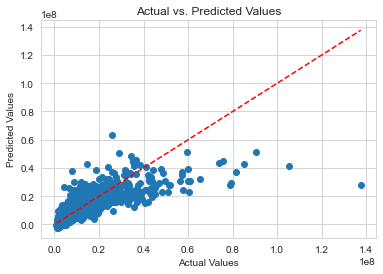

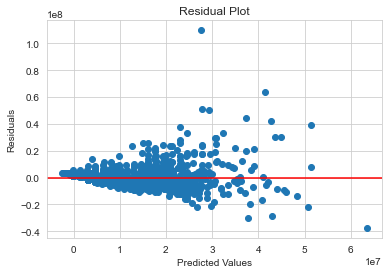

In [506]:
plot_predicted_v_actual(y_train, linear_pred)
plot_residuals(y_train, linear_pred)


The residual plot informs us that the residual (difference between the predicted and actual value) increases as the predicted values increases in size. This is a symptom of heteroscedasticity (https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/). Hence, we will employ regression techinques to reduce this. 

We can also observe a clear downwards trend within the residual graph which hints at the presence of a non-linear relationship in the dataset hence, prompting us to attempt polynomial fits as well. It is possible that multicolinearity is present within the dataset

In [507]:
from sklearn.metrics import r2_score, mean_squared_error
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred)
print("linear MSE score: ", r_squared_lin)

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
from sklearn.model_selection import cross_val_score, KFold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
cross_val_results_lin = cross_val_score(LinearRegression(), X_train, y_train, cv=kf)
print(f'Cross-Validation Results (Accuracy): {cross_val_results_lin}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin.mean(), cross_val_results_lin.std()))



linear R^2 score:  0.5715473449277324
linear MSE score:  0.5715473449277324
Cross-Validation Results (Accuracy): [0.65883494 0.57420244 0.41562549 0.68136143 0.63383548 0.59584451
 0.51967707 0.52009656 0.57255344 0.56083207]
0.57 accuracy with a standard deviation of 0.07


Testing for the presence of mulitcolinearity as per https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Multicollinearity%20is%20a%20statistical%20phenomenon,relationship%20among%20the%20predictor%20variables.
using the VIF value 
https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/#

In [508]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# calculating VIF for each feature 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                          for i in range(len(X_train.columns))] 


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [509]:
vif_data

,feature,VIF
0,weekly_views,1.521080
1,cumulative_weeks_in_top_10,1.309080
2,runtime,3.229953
3,number_of_seasons,1.070473
4,is_staggered_launch,1.123126
5,language_English,inf
6,language_Non-English,inf
7,type_Films,inf
8,type_TV,inf
9,available_globally_No,1.294412


It is clear that multiple features have high multicolinearity hence we will employ PCA to tackle this issue

In [510]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale data before applying PCA
scaling=StandardScaler()

# Use fit and transform method 
scaling.fit(X_train)
Scaled_data=scaling.transform(X_train)
 
# Set the n_components=3
principal=PCA(n_components=7)
principal.fit(Scaled_data)
x_train_after_pca =principal.transform(Scaled_data)

# Check the dimensions of data after PCA
print(x_train_after_pca.shape)

# check how much variance is explained by each principal component
print(principal.explained_variance_ratio_)




(1492, 7)
[0.28145177 0.20735899 0.12019543 0.10004715 0.0926528  0.08269444
 0.06043284]


Retraining after the PCA reduced dimensionality to 7 features 

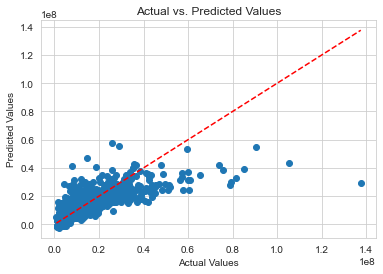

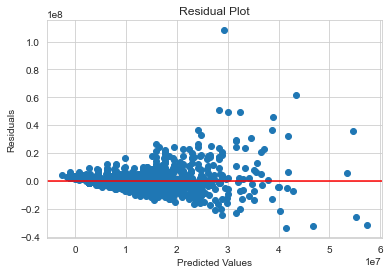

In [511]:
linear_model_after_pca = LinearRegression(fit_intercept=True).fit(x_train_after_pca,y_train)
linear_pred_after_pca = linear_model_after_pca.predict(x_train_after_pca)

plot_predicted_v_actual(y_train, linear_pred_after_pca)
plot_residuals(y_train, linear_pred_after_pca)

Now we proceed onto generalization 

In [512]:
(x_train_after_pca == 0).sum().sum()
# this means that the modified dataset is not sparse 

0

In [513]:

print(x_train_after_pca.shape)

(1492, 7)


In [514]:
vif_data_pca = pd.DataFrame() 
vif_data_pca["VIF"] = [variance_inflation_factor(x_train_after_pca, i) 
                          for i in range(len(x_train_after_pca[0]))] 

In [515]:
vif_data_pca

,VIF
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0


In [516]:
#calculating the R-squared score 
r_squared_lin = r2_score(y_train, linear_pred_after_pca)
print("linear R^2 score: ", r_squared_lin)

#calculating the mean squared error(MSE)
mse_lin = mean_squared_error(y_train, linear_pred_after_pca)
print("linear MSE score: ", r_squared_lin)

#https://www.geeksforgeeks.org/cross-validation-machine-learning/
num_folds_pca = 500
kf_pca = KFold(n_splits = num_folds_pca, shuffle = True, random_state = 42)
cross_val_results_lin_after_pca = cross_val_score(LinearRegression(), x_train_after_pca, y_train, cv = kf_pca)
print(f'PCA Cross-Validation Results (Accuracy): {cross_val_results_lin_after_pca}')
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val_results_lin_after_pca.mean(), cross_val_results_lin_after_pca.std()))

linear R^2 score:  0.5533034628872449
linear MSE score:  0.5533034628872449
PCA Cross-Validation Results (Accuracy): [-2.36921412e-01  8.18436849e-01  2.92310145e-01  6.00866042e-01
  7.47015882e-01 -4.28289289e+00 -5.37891102e+00 -9.12762389e-02
  1.55177425e-01 -9.14410952e+00 -7.86286128e+00  9.06097294e-01
  3.05722068e-01 -2.07663564e+00  8.23317896e-01  6.79682379e-01
 -1.09354715e+01  8.50227930e-01 -1.00069586e+00  1.78314182e-01
  5.06932337e-01  2.55593402e-01 -8.95720953e-02  6.11256867e-01
  7.54666860e-01  6.53589926e-01  9.63247342e-02  8.41237333e-01
 -8.81366494e+00  7.25076371e-01  8.96355479e-01  6.41343702e-01
 -2.12993319e+02 -1.17657904e+01 -3.97147832e+01  7.39080890e-01
  8.11917846e-01 -2.36726501e+00  8.56656035e-01  9.43298659e-01
 -2.13094832e+00  2.26933834e-02 -1.94396498e+00  6.41056149e-01
  9.52260056e-01  8.69304182e-02  8.26849993e-01  1.48131697e-01
 -2.75181861e-01 -7.89052827e-01  5.78799268e-01  4.89629096e-01
  5.74277372e-01  4.11783085e-01 -3.65


# We should ask about the fix to heteroscedasticity faced - doesnt seem to simple??

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


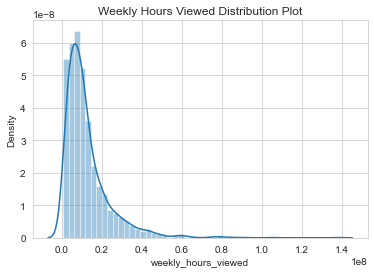

In [517]:
# Data distribution
plt.title('Weekly Hours Viewed Distribution Plot')
sns.distplot(netflix['weekly_hours_viewed'])
plt.show()

In [518]:
y = (netflix["weekly_hours_viewed"]).values
X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [519]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
 
pr = PolynomialFeatures(degree = 4)
X_poly = pr.fit_transform(X_train)
lr_2 = LinearRegression()
lr_2.fit(X_poly, y_train)
#Predict results
y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
#lr_2.fit(pr.fit_transform(X_test), y_test)
y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))


In [520]:
def poly_plot_predicted_v_actual(y_train, y_pred):
  #helps us understand the relationship between the predicted and the actual values
  plt.scatter(y_train, y_pred)
  plt.plot(y_train, lr_2.predict(pr.fit_transform(X_train)), color = 'firebrick', linestyle='--')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Actual vs. Predicted Values')
  plt.show()

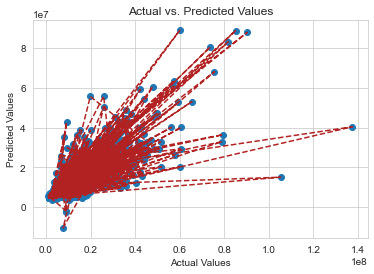

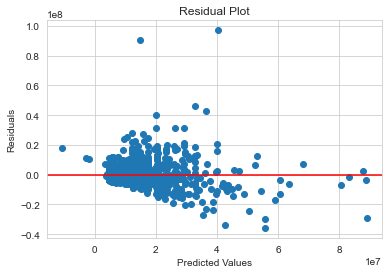

In [521]:
poly_plot_predicted_v_actual(y_train, y_pred_poly)
plot_residuals(y_train, y_pred_poly)

In [522]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.square(np.subtract(y,pred)).mean()

In [523]:
# linear train and test MSE
linear_test_pred = linear_model.predict(X_test)

linear_train_MSE = MSE(y_train, linear_pred.flatten())
linear_test_MSE = MSE(y_test, linear_test_pred.flatten())
print("Linear Train MSE\t", str(linear_train_MSE))
print("Linear Test MSE\t", str(linear_test_MSE))
linear_train_PCA_MSE = MSE(y_train, linear_pred_after_pca.flatten())
print("Linear Train with PCA MSE\t", str(linear_train_PCA_MSE))

Linear Train MSE	 58508926629822.13
Linear Test MSE	 41942324512587.58
Linear Train with PCA MSE	 61000286977606.57


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [524]:
# polynomial train and test MSE at degree 4
poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_train_MSE))
poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
print("Polynomial Train MSE\t", str(poly_test_MSE))

Polynomial Train MSE	 52629940945372.67
Polynomial Train MSE	 1219829058809169.0


In [525]:
# compare train and test MSE for polynomials of degrees 1-7
for i in range(7):
  pr = PolynomialFeatures(degree = i+1)
  X_poly = pr.fit_transform(X_train)
  lr_2 = LinearRegression()
  lr_2.fit(X_poly, y_train)
  #Predict results
  y_pred_poly = lr_2.predict(X_poly)  # Polynomial Regression
  y_test_pred_poly = lr_2.predict(pr.fit_transform(X_test))
  
  poly_train_MSE = MSE(y_train, y_pred_poly.flatten())
  print(("Polynomial Train MSE" + " at degree " + str(i+1) + "\t"), str(poly_train_MSE))
  poly_test_MSE = MSE(y_test, y_test_pred_poly.flatten())
  print(("Polynomial Test MSE" + " at degree " + str(i+1) + "\t"), str(poly_test_MSE))


Polynomial Train MSE at degree 1	 58508926629822.13
Polynomial Test MSE at degree 1	 41942324512586.83
Polynomial Train MSE at degree 2	 37160692866043.11
Polynomial Test MSE at degree 2	 32307355545434.133
Polynomial Train MSE at degree 3	 42082286104028.375
Polynomial Test MSE at degree 3	 39641701538503.055
Polynomial Train MSE at degree 4	 52629940945372.67
Polynomial Test MSE at degree 4	 1219829058809169.0
Polynomial Train MSE at degree 5	 82187317510436.12
Polynomial Test MSE at degree 5	 1.777568934124226e+16
Polynomial Train MSE at degree 6	 90566519845611.92
Polynomial Test MSE at degree 6	 1.8173598982519468e+16
Polynomial Train MSE at degree 7	 105573098556877.89
Polynomial Test MSE at degree 7	 5075823813185183.0


In [526]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [527]:
from numpy.random import rand, randn
def generate_data(n, w):
    X = randn(n,len(w))
    y = X@w
    return X, y
def generate_noisy_data(n, w):
    X = randn(n,len(w))
    y = X@w + .1*randn(n)
    return X, y

In [556]:
y = (netflix["weekly_hours_viewed"]).values
X = (netflix.copy().drop(['weekly_hours_viewed'], axis=1)).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alpha_ridge=.1
alpha_lasso=.1

w_randn = randn(30)
w_ridge = Ridge(alpha = alpha_ridge).fit(X,y).coef_
w_lasso = Lasso(alpha = alpha_lasso).fit(X,y).coef_
w_nonneg = LinearRegression(positive=True).fit(X,y).coef_
w_sparse = w_randn*(abs(w_randn) > 1)


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.28181e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


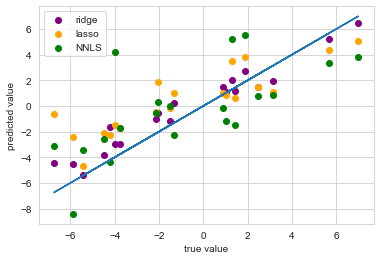

In [557]:
#w_randn
X,y = generate_data(30, w_randn)
Xtest,ytest = generate_data(20,w_randn)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

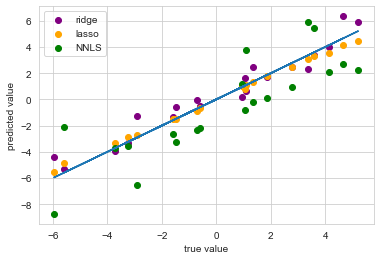

In [558]:
#w_sparse
X,y = generate_data(30, w_sparse)
Xtest,ytest = generate_data(20,w_sparse)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

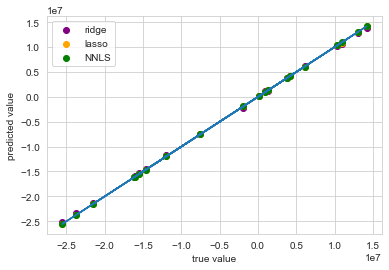

In [559]:
#w_nonneg
#w_nonneg = LinearRegression(positive=True).fit(X,y).coef_
X,y = generate_data(30, w_nonneg)
Xtest,ytest = generate_data(20,w_nonneg)

yhat_ridge = Ridge(alpha = alpha_ridge).fit(X,y).predict(Xtest)
yhat_lasso = Lasso(alpha = alpha_lasso).fit(X,y).predict(Xtest)
yhat_nonneg = LinearRegression(positive=True).fit(X,y).predict(Xtest)

plt.plot(ytest,ytest)
plt.scatter(ytest, yhat_ridge, label="ridge", color="purple")
plt.scatter(ytest, yhat_lasso, label="lasso", color="orange")
plt.scatter(ytest, yhat_nonneg, label="NNLS", color="green")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.legend()

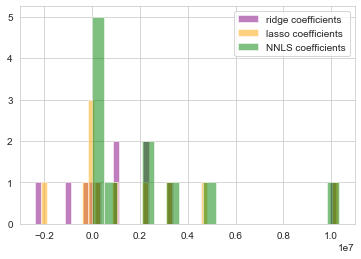

In [560]:
plt.hist(w_ridge, label="ridge coefficients", bins=50, alpha=.5, color="purple")
plt.hist(w_lasso, label="lasso coefficients", bins=50, alpha=.5, color="orange")
plt.hist(w_nonneg, label="NNLS coefficients", bins=20, alpha=.5, color="green")
plt.legend()

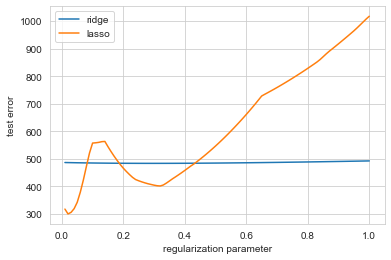

In [561]:
# cross validate over regularization parameter alpha
np.random.seed(6)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

ridge_error = []
lasso_error = []
alphas = np.linspace(.01,1,100)
for alpha in alphas:
    yhat_ridge = Ridge(alpha = alpha).fit(X,y).predict(Xtest)
    ridge_error.append(sum((ytest - yhat_ridge)**2))
    yhat_lasso = Lasso(alpha = alpha).fit(X,y).predict(Xtest)
    lasso_error.append(sum((ytest - yhat_lasso)**2))
plt.plot(alphas, ridge_error, label="ridge")
plt.plot(alphas, lasso_error, label="lasso")
plt.ylabel("test error")
plt.xlabel("regularization parameter")
plt.legend()